Notebook Structure: Email Summarization Model

---

#### 🟩 1. **Setup & Configuration**
- Import libraries (TensorFlow, pandas, etc.)
- Set seeds for reproducibility
- Mixed precision policy
- Define constants like `MAX_LEN`, `BATCH_SIZE`, `EPOCHS`, `VOCAB_SIZE`

---

#### 🟦 2. **Load & Inspect Data**
- Load `final_summary.jsonl`
- Show sample rows (`email_body`, `summary`)
- Basic EDA (length distributions, null checks)

---

#### 🟧 3. **Tokenizer Preparation**
- Use `TextVectorization` from Keras or a custom tokenizer
- Fit tokenizer on both `email_body` and `summary`
- Save tokenizer config (optional for deployment)

---

#### 🟨 4. **Prepare Data Pipeline**
- Tokenize and pad sequences
- Convert to TensorFlow `tf.data.Dataset`
- Create train/val splits
- Use `.shuffle().batch().prefetch()` for performance

---

#### 🟫 5. **Model Architecture**
- Plug in your **final NILESH-AI 420M model architecture** (already built)
- Confirm output shapes and total parameters
- Print model summary

---

#### 🟪 6. **Training Configuration**
- Compile model (losses: `SparseCategoricalCrossentropy`, optimizer: Adam or AdamW)
- Add callbacks:
  - ModelCheckpoint
  - EarlyStopping
  - TensorBoard (optional)

---

#### 🔵 7. **Train the Model**
- Fit the model with `model.fit()`
- Plot training/validation loss & accuracy curves

---

#### 🟫 8. **Evaluation**
- Generate sample summaries
- Compare model predictions vs. true summaries
- Add BLEU or ROUGE scores (optional)

---

#### 🟩 9. **Export & Save**
- Save model using `model.save('NileshEmailSummarizer')`
- Save tokenizer if needed
- Save metrics and training logs

---

#### 🟦 10. **(Optional) Inference Script**
- Write a simple function: `def summarize_email(email_text):`
- Load model + tokenizer
- Return generated summary

---


In [4]:
# 📦 Imports & Setup
import os
import numpy as np
import pandas as pd
import random
import json
import tensorflow as tf
from tensorflow.keras import mixed_precision

# 🧪 Seed Everything for Full Reproducibility
def set_global_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_global_seed(42)

# 🚀 Mixed Precision (use float16 on 4070)
mixed_precision.set_global_policy("mixed_float16")

# ✅ GPU Memory Growth Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU Detected: {gpus[0].name}")
    except RuntimeError as e:
        print("❌ GPU error:", e)
else:
    print("❌ No GPU detected. Falling back to CPU.")

# 📐 Model Hyperparameters
MAX_LEN = 384               # ⬅️ Safer for your 8GB GPU (half sequence size)
VOCAB_SIZE = 32000          # ⬅️ Big vocab for your project
EMBED_DIM = 640             # ⬅️ Slightly reduced, 768d efficient for 4070
NUM_HEADS = 8               # ⬅️ 12 heads instead of 16 (memory safe)
FF_DIM = 2560               # ⬅️ Reduced FFN size
ENCODER_LAYERS = 8          # ⬅️ Lighter encoder (was 11)
DECODER_LAYERS = 8          # ⬅️ Lighter decoder
BATCH_SIZE = 2              # ⬅️ Safer to start with batch_size=4
EPOCHS = 20                 # ⬅️ Enough epochs
AUTOTUNE = tf.data.AUTOTUNE

print("\n🔧 Environment & hyperparameters set up successfully.")


TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle


🔎 Loading dataset...
✅ Found 21 files in directory 'C:\Users\Admin\AI_email_Agent\Database\Database_AI_Email'.



📂 Loading files: 100%|██████████| 21/21 [00:00<00:00, 39.69it/s]

✅ Parsed 8108 total input-output pairs.


🔍 Random Samples:


,input,target
5598,What reminder does the email below provide?\n\...,Team building activity Friday 4 PM at the park.
4742,"Based on the following policy-related email, w...",New travel policy effective next week.
6903,"Based on the schedule email below, what meetin...",Server maintenance completed successfully.
6943,"Based on the schedule email below, what meetin...",Agenda for tomorrow's meeting attached.
2115,Summarize the key updates or insights shared i...,Monthly company newsletter received for April.



🩺 Null Values Check:
input     0
target    0
dtype: int64

📊 Input/Target Length Statistics:


,input_len,target_len
count,8108.000000,8108.000000
mean,25.450543,7.452639
std,4.281122,2.647798
min,11.000000,3.000000
25%,23.000000,6.000000
50%,25.000000,7.000000
75%,27.000000,9.000000
max,45.000000,18.000000


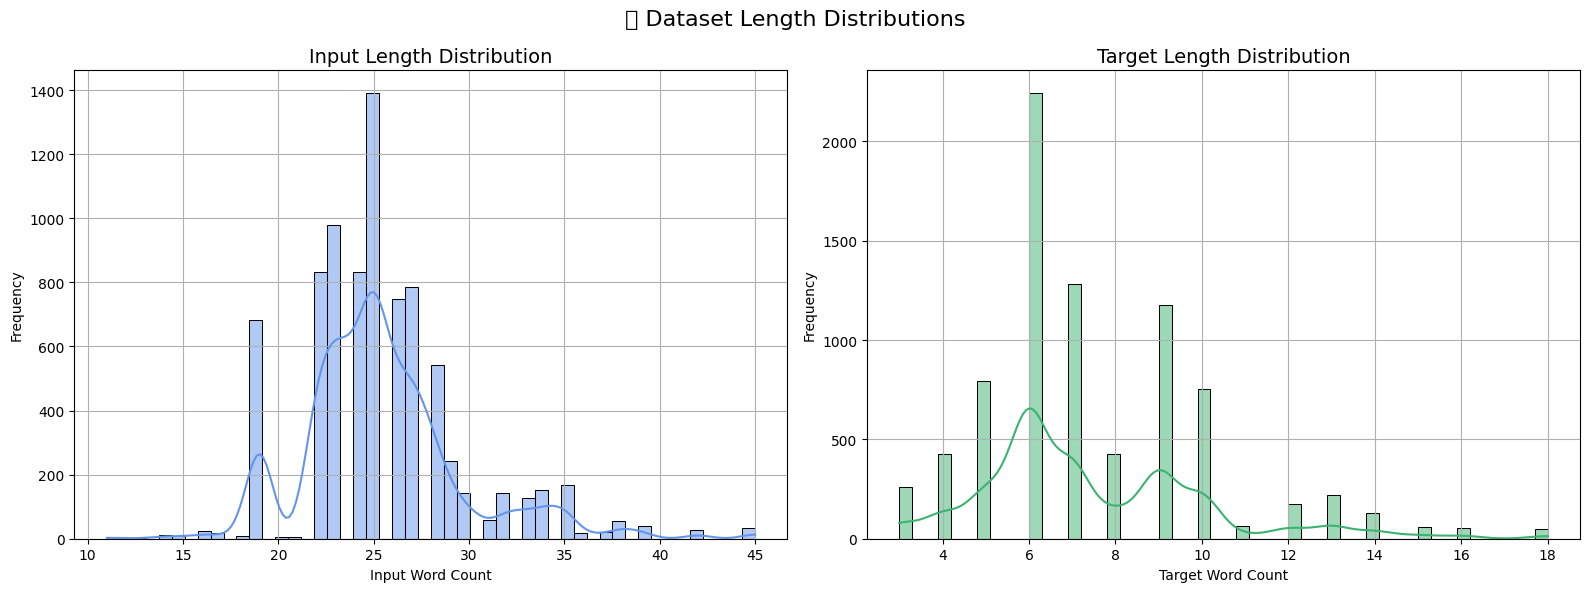


✅ Data inspection and analysis completed.


In [3]:
# 📦 Imports
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()

# 🟩 Configurations
DATA_DIR = r"C:\Users\Admin\AI_email_Agent\Database\Database_AI_Email"

# 🧠 Flexible Smart Pair Extractor
def extract_all_pairs(file_path):
    records = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                data = json.loads(line.strip())
            except Exception:
                try:
                    data = eval(line.strip())
                except Exception:
                    continue

            # Try multiple structures
            for in_key, out_key in [
                ("email_body", "summary"),
                ("question", "answer"),
                ("body", "summary"),
                ("input", "output")
            ]:
                if in_key in data and out_key in data:
                    records.append({"input": data[in_key], "target": data[out_key]})
                    break
    return records

# 📥 Load & Merge All Records
def load_all_records(directory):
    all_records = []
    all_files = list(Path(directory).glob("*.json")) + list(Path(directory).glob("*.jsonl"))
    print(f"✅ Found {len(all_files)} files in directory '{directory}'.\n")
    
    for f in tqdm(all_files, desc="📂 Loading files"):
        all_records.extend(extract_all_pairs(f))
    
    print(f"✅ Parsed {len(all_records)} total input-output pairs.\n")
    return pd.DataFrame(all_records)

# 🚀 Load Dataset
print("\n🔎 Loading dataset...")
df = load_all_records(DATA_DIR)

# 🔍 Preview
if not df.empty:
    print("\n🔍 Random Samples:")
    display(df.sample(min(5, len(df))))
else:
    print("❗ Dataset is empty.")

# 🩺 Null Checks
print("\n🩺 Null Values Check:")
print(df.isnull().sum())

# 📏 Length Analysis
df['input_len'] = df['input'].astype(str).apply(lambda x: len(x.split()))
df['target_len'] = df['target'].astype(str).apply(lambda x: len(x.split()))

# 📊 Statistical Summary
print("\n📊 Input/Target Length Statistics:")
display(df[['input_len', 'target_len']].describe())

# 📈 Visualize Distributions
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['input_len'], bins=50, color='cornflowerblue', kde=True)
plt.title("Input Length Distribution", fontsize=14)
plt.xlabel("Input Word Count")
plt.ylabel("Frequency")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(df['target_len'], bins=50, color='mediumseagreen', kde=True)
plt.title("Target Length Distribution", fontsize=14)
plt.xlabel("Target Word Count")
plt.ylabel("Frequency")
plt.grid(True)

plt.suptitle("📊 Dataset Length Distributions", fontsize=16)
plt.tight_layout()
plt.show()

print("\n✅ Data inspection and analysis completed.")


In [4]:
import os
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split

# 🛠 Settings
VOCAB_SIZE = 32000
MAX_LEN_INPUT = 384
MAX_LEN_TARGET = 384
BATCH_SIZE = 2
SEED = 42
VECTOR_SAVE_DIR = "vectorizers"  # Save folder
os.makedirs(VECTOR_SAVE_DIR, exist_ok=True)  # Create if not exists

# 🧹 Custom Standardization
def custom_standardization(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, r'\n', ' ')
    text = tf.strings.regex_replace(text, r'\s+', ' ')
    text = tf.strings.regex_replace(text, r"[^a-zA-Z0-9\s.,!?'\"]", '')
    text = tf.strings.strip(text)
    return text

# 🔤 Create Input and Target Vectorizers
input_vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN_INPUT,
    standardize=custom_standardization,
    pad_to_max_tokens=True,
)

target_vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN_TARGET,
    standardize=custom_standardization,
    pad_to_max_tokens=True,
)

# ⚡ Adapt vectorizers
input_ds = tf.data.Dataset.from_tensor_slices(df['input'].astype(str).values).batch(256)
target_ds = tf.data.Dataset.from_tensor_slices(df['target'].astype(str).values).batch(256)

input_vectorizer.adapt(input_ds)
target_vectorizer.adapt(target_ds)

print("✅ Vectorizers built and adapted successfully.")

# 💾 Save vocabularies instead of full vectorizers
# Save input vocab
input_vocab = input_vectorizer.get_vocabulary()
with open(os.path.join(VECTOR_SAVE_DIR, "input_vocab.txt"), "w", encoding="utf-8") as f:
    for token in input_vocab:
        f.write(token + "\n")

# Save target vocab
target_vocab = target_vectorizer.get_vocabulary()
with open(os.path.join(VECTOR_SAVE_DIR, "target_vocab.txt"), "w", encoding="utf-8") as f:
    for token in target_vocab:
        f.write(token + "\n")

print("✅ Vectorizer vocabularies saved as .txt files!")

# 🧹 Preprocessing Function
@tf.function
def preprocess(input_text, target_text):
    input_vec = input_vectorizer(input_text)
    target_vec = target_vectorizer(target_text)
    return {"encoder_input": input_vec, "decoder_input": input_vec}, target_vec

# 📂 Train/Validation Split
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    df['input'].values,
    df['target'].values,
    test_size=0.1,
    random_state=SEED,
    shuffle=True,
)

print(f"✅ Data Split: {len(train_inputs)} Training Samples, {len(val_inputs)} Validation Samples.")

# 🛠 Dataset Builder
def build_dataset(inputs, targets, batch_size=BATCH_SIZE, training=True):
    ds = tf.data.Dataset.from_tensor_slices((inputs, targets))
    if training:
        ds = ds.shuffle(buffer_size=min(4096, len(inputs)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# 🚀 Final Train & Validation Datasets
train_dataset = build_dataset(train_inputs, train_targets, training=True)
val_dataset = build_dataset(val_inputs, val_targets, training=False)

print("✅ TensorFlow Datasets are 100% ready!")


✅ Vectorizers built and adapted successfully.
✅ Vectorizer vocabularies saved as .txt files!
✅ Data Split: 7297 Training Samples, 811 Validation Samples.
✅ TensorFlow Datasets are 100% ready!


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.mixed_precision import set_global_policy

# ✅ Mixed Precision Policy
set_global_policy("mixed_float16")

# ========== Model Config ========== #
MAX_LEN_INPUT = 384
MAX_LEN_TARGET = 384
VOCAB_SIZE = 32000
EMBED_DIM = 640           # 🔥 optimized for 4070 (was 1024)
NUM_HEADS = 8             # 🔥 lighter attention (was 16)
FF_DIM = 2560             # 🔥 lighter feed-forward (was 4096)
ENCODER_LAYERS = 8
DECODER_LAYERS = 8

# ========== Positional Encoding ========== #
def get_positional_encoding(maxlen, embed_dim):
    pos = tf.range(maxlen)[:, tf.newaxis]
    i = tf.cast(tf.range(embed_dim)[tf.newaxis, :], tf.float32)
    angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(embed_dim, tf.float32))
    angle_rads = tf.cast(pos, tf.float32) * angle_rates
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return tf.cast(pos_encoding[tf.newaxis, ...], tf.float32)

# ========== Transformer Encoder Block ========== #
def transformer_encoder_block(embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = Input(shape=(None, embed_dim))
    x = tf.cast(inputs, tf.float16)

    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(x, x)
    attn = layers.Dropout(rate)(attn)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    ffn = layers.Dense(ff_dim, activation='gelu')(out1)
    ffn = layers.Dense(embed_dim)(ffn)
    ffn = layers.Dropout(rate)(ffn)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
    return Model(inputs, out2)

# ========== Transformer Decoder Block ========== #
def transformer_decoder_block(embed_dim, num_heads, ff_dim, rate=0.1):
    enc_inputs = Input(shape=(None, embed_dim))
    dec_inputs = Input(shape=(None, embed_dim))

    x_enc = tf.cast(enc_inputs, tf.float16)
    x_dec = tf.cast(dec_inputs, tf.float16)

    self_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(x_dec, x_dec)
    self_attn = layers.Dropout(rate)(self_attn)
    norm1 = layers.LayerNormalization(epsilon=1e-6)(x_dec + self_attn)

    cross_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(norm1, x_enc)
    cross_attn = layers.Dropout(rate)(cross_attn)
    norm2 = layers.LayerNormalization(epsilon=1e-6)(norm1 + cross_attn)

    ffn = layers.Dense(ff_dim, activation='gelu')(norm2)
    ffn = layers.Dense(embed_dim)(ffn)
    ffn = layers.Dropout(rate)(ffn)
    out = layers.LayerNormalization(epsilon=1e-6)(norm2 + ffn)
    return Model([dec_inputs, enc_inputs], out)

# ========== Build Final Model ========== #
def build_nilesh_model():
    encoder_input = Input(shape=(MAX_LEN_INPUT,), name='encoder_input')
    decoder_input = Input(shape=(MAX_LEN_INPUT,), name='decoder_input')

    embedding = layers.Embedding(VOCAB_SIZE, EMBED_DIM, dtype='float32')
    pos_enc = get_positional_encoding(MAX_LEN_INPUT, EMBED_DIM)

    enc_embed = tf.cast(embedding(encoder_input), tf.float16) + tf.cast(pos_enc[:, :MAX_LEN_INPUT, :], tf.float16)
    dec_embed = tf.cast(embedding(decoder_input), tf.float16) + tf.cast(pos_enc[:, :MAX_LEN_INPUT, :], tf.float16)

    # === Encoder === #
    x = enc_embed
    for _ in range(ENCODER_LAYERS):
        x = transformer_encoder_block(EMBED_DIM, NUM_HEADS, FF_DIM)(x)
    encoder_output = x

    # === Decoder === #
    y = dec_embed
    for _ in range(DECODER_LAYERS):
        y = transformer_decoder_block(EMBED_DIM, NUM_HEADS, FF_DIM)([y, encoder_output])

    # === Output Heads === #
    pointer_logits = layers.Dense(VOCAB_SIZE)(y)
    token_output = layers.Activation('softmax', name='token_output')(pointer_logits)

    avg = layers.GlobalAveragePooling1D()(y)
    score_output = layers.Dense(1, activation='sigmoid', name='score_output')(avg)

    return Model(inputs=[encoder_input, decoder_input], outputs=[token_output, score_output])

# ========== Instantiate ========== #
nilesh_model = build_nilesh_model()
nilesh_model.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 384)]        0           []                               
                                                                                                  
 encoder_input (InputLayer)     [(None, 384)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 384, 640)     20480000    ['encoder_input[0][0]',          
                                                                  'decoder_input[0][0]']          
                                                                                                  
 tf.cast (TFOpLambda)           (None, 384, 640)     0           ['embedding[0][0]']       

In [6]:
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import callbacks, losses, metrics
import os

# ⚙️ CONFIG
TOTAL_EPOCHS = 20
BASE_LR = 1e-5
MAX_LR = 3e-4
WEIGHT_DECAY = 1e-4
CHECKPOINT_PATH = "Nilesh_Model_Best.keras"
BACKUP_DIR = "./backup_checkpoints"
TENSORBOARD_LOG_DIR = "logs"

# ⚙️ Compile the Model
loss_token = losses.SparseCategoricalCrossentropy(from_logits=False)
loss_score = losses.BinaryCrossentropy()

# ✅ Optimizer with Mixed Precision Loss Scaling
base_optimizer = AdamW(
    learning_rate=MAX_LR,
    weight_decay=WEIGHT_DECAY
)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
    base_optimizer,
    dynamic=True  # 🔥 Automatic dynamic scaling
)

nilesh_model.compile(
    optimizer=optimizer,
    loss={
        'token_output': loss_token,
        'score_output': loss_score
    },
    loss_weights={
        'token_output': 1.0,
        'score_output': 0.2
    },
    metrics={
        'token_output': [metrics.SparseCategoricalAccuracy(name="accuracy")],
        'score_output': [metrics.BinaryAccuracy(name="binary_accuracy")]
    }
)

# 📈 OneCycle Learning Rate Scheduler
def one_cycle_scheduler(epoch, lr):
    step_size = TOTAL_EPOCHS // 2
    if epoch < step_size:
        return BASE_LR + (MAX_LR - BASE_LR) * (epoch / step_size)
    else:
        return MAX_LR - (MAX_LR - BASE_LR) * ((epoch - step_size) / step_size)

onecycle_cb = callbacks.LearningRateScheduler(one_cycle_scheduler, verbose=1)

# 📦 Callbacks Setup
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

earlystopping_cb = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

tensorboard_cb = callbacks.TensorBoard(
    log_dir=TENSORBOARD_LOG_DIR,
    histogram_freq=1,
    write_graph=True,
    profile_batch=0
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1,
)

backup_cb = callbacks.BackupAndRestore(
    backup_dir=BACKUP_DIR
)

callbacks_list = [
    checkpoint_cb,
    earlystopping_cb,
    tensorboard_cb,
    reduce_lr_cb,
    backup_cb,
    onecycle_cb
]

# ✅ Optional: Restore Latest Checkpoint Automatically
if os.path.exists(CHECKPOINT_PATH):
    print("🔄 Loading model from checkpoint...")
    nilesh_model = tf.keras.models.load_model(CHECKPOINT_PATH, compile=True)
else:
    print("🚀 No checkpoint found. Starting fresh...")

print("\n✅ Model compiled successfully with Loss Scaling and Callbacks Ready! 🚀")


🚀 No checkpoint found. Starting fresh...

✅ Model compiled successfully with Loss Scaling and Callbacks Ready! 🚀


In [7]:
# 📈 Plot function
def plot_training_curves(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Train Loss", marker='o')
    plt.plot(history["val_loss"], label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss per Epoch", fontsize=16)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

In [8]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import gc  # Added for memory cleaning

# ========= Train Function ========= #
def train_model(model, train_dataset, val_dataset, epochs=15, checkpoint_dir="checkpoints"):
    print("\n🚀 Starting Custom Training Loop...")

    start_time = time.time()
    os.makedirs(checkpoint_dir, exist_ok=True)

    # --- Create checkpoint objects ---
    checkpoint = tf.train.Checkpoint(model=model, optimizer=model.optimizer, epoch=tf.Variable(0))
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

    # --- Restore if checkpoint exists ---
    if manager.latest_checkpoint:
        checkpoint.restore(manager.latest_checkpoint).expect_partial()
        start_epoch = int(checkpoint.epoch.numpy())
        print(f"✅ Restored from {manager.latest_checkpoint} | Starting from epoch {start_epoch}")
    else:
        start_epoch = 0
        print("🚀 No checkpoint found. Starting fresh!")

    train_loss_tracker = tf.keras.metrics.Mean(name="train_loss")
    val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")

    best_val_loss = np.inf
    patience = 5
    wait = 0

    history = {"train_loss": [], "val_loss": []}

    # --- TensorBoard Writer ---
    tb_writer = tf.summary.create_file_writer("logs")

    # ========== Main Training Loop ========== #
    for epoch in range(start_epoch, epochs):
        print(f"\n🌟 Epoch {epoch+1}/{epochs}")

        # Training
        for step, (x_batch, y_batch) in tqdm(enumerate(train_dataset), total=len(train_dataset), desc="Training", ncols=100):
            with tf.GradientTape() as tape:
                token_preds, score_preds = model(x_batch, training=True)
                loss_token = tf.keras.losses.sparse_categorical_crossentropy(y_batch, token_preds)
                loss_score = tf.keras.losses.binary_crossentropy(tf.ones_like(score_preds), score_preds)
                loss = tf.reduce_mean(loss_token) + 0.2 * tf.reduce_mean(loss_score)
                scaled_loss = model.optimizer.get_scaled_loss(loss)

            scaled_grads = tape.gradient(scaled_loss, model.trainable_variables)
            grads = model.optimizer.get_unscaled_gradients(scaled_grads)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

            train_loss_tracker.update_state(loss)

        # Validation
        for x_batch_val, y_batch_val in val_dataset:
            token_preds, score_preds = model(x_batch_val, training=False)
            loss_token = tf.keras.losses.sparse_categorical_crossentropy(y_batch_val, token_preds)
            loss_score = tf.keras.losses.binary_crossentropy(tf.ones_like(score_preds), score_preds)
            val_loss = tf.reduce_mean(loss_token) + 0.2 * tf.reduce_mean(loss_score)
            val_loss_tracker.update_state(val_loss)

        # Record metrics
        train_epoch_loss = train_loss_tracker.result().numpy()
        val_epoch_loss = val_loss_tracker.result().numpy()

        history["train_loss"].append(train_epoch_loss)
        history["val_loss"].append(val_epoch_loss)

        print(f"✅ Epoch {epoch+1} | Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")

        with tb_writer.as_default():
            tf.summary.scalar("train_loss", train_epoch_loss, step=epoch)
            tf.summary.scalar("val_loss", val_epoch_loss, step=epoch)

        # Save best model
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            wait = 0
            model.save(os.path.join(checkpoint_dir, f"best_model_epoch{epoch+1}.keras"))
            print(f"💾 Saved best model at epoch {epoch+1}")
        else:
            wait += 1
            print(f"⚠️ No improvement. Patience {wait}/{patience}")

        # Early Stopping
        if wait >= patience:
            print("🛑 Early stopping triggered.")
            break

        # Save checkpoint every epoch
        checkpoint.epoch.assign(epoch + 1)
        manager.save()
        print(f"💾 Saved checkpoint for epoch {epoch+1}")

        # ========== NEW: Clean memory ==========
        gc.collect()
        tf.keras.backend.clear_session()
        print(f"🧹 Memory cleaned after epoch {epoch+1}")

        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

    total_time = (time.time() - start_time) / 60
    print(f"\n✅ Training completed in {total_time:.2f} minutes.")

    model.save("Nilesh_Model_Final.keras")
    print("💾 Final full model saved as 'Nilesh_Model_Final.keras'.")

    plot_training_curves(history)
    return history


In [ ]:
history = train_model(nilesh_model, train_dataset, val_dataset, epochs=50)



🚀 Starting Custom Training Loop...
✅ Restored from checkpoints\ckpt-29 | Starting from epoch 29

🌟 Epoch 30/50


Training:  24%|███████████▊                                      | 858/3648 [16:53<54:16,  1.17s/it]